# Molecular Informatics Project
### Created by: Karla Vela 
### Created on 10/25/24


#### Step 1: Import libraries

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import time
import torch
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import os
from torch.utils.tensorboard import SummaryWriter
import random
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_geometric.transforms as T
from torch_geometric.transforms import Compose
from torch_geometric.data import Data, download_url, extract_gz
from torch_geometric.nn import GAE, GCNConv, VGAE
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.utils import train_test_split_edges, negative_sampling, degree
import numpy as np

#### Step 2: Import data - DisGeNET disease associations and BioGRID network

- First, import DisGeNET data. For the logistic regression, genes associated with tuberculosis (TB) will be collected to be the positive labels. More genes will be propagated using these positive genes by using MONDO. Then random sampling will be done for the negative examples. Finally, logistic regression is trained on this set. This is the baseline model. 

- For the GAE and VGAE, the TB positive genes will also be collected and then used in the seed connector algorithm (SCA) to propagate more genes. This is the solution problem where we propagate more positive genes by using a different method instead of using the MONDO ontology structrue. Then the module and genes of this module will be verified by checking the module structure agains other randomly sampled modules created by the SCA using random proteins. The genes propagated by the SCA and the positive genes obtained from the DisGeNET will also under go a GO functional simalarity function to make sure the SCA genes are indeed likely candidates for postive TB examples. Then these propagated genesa are added to the DisGeNET set to be used for the GAE and VGAE models. 

<span style="color:teal; font-size:25px; font-weight:bold">Get DisGeNET data </span>


In [3]:
SEED = 42

# read in disgnet disease gene associations
disgenet_raw = pd.read_csv('../data/processed/propagated_disgenet_genes.tsv', delimiter= '\t')
disgenet_raw.head(15)

,gene_id,gene_name,mondo_id,mondo_term
0,2,A2M,MONDO:0004975,Alzheimer disease
1,2,A2M,MONDO:0021063,malignant colon neoplasm
2,2,A2M,MONDO:0005401,colonic neoplasm
3,2,A2M,MONDO:0002050,depressive disorder
4,2,A2M,MONDO:0005376,membranous glomerulonephritis
5,2,A2M,MONDO:0010200,Wilson disease
6,2,A2M,MONDO:0005155,cirrhosis of liver
7,2,A2M,MONDO:0002691,liver cancer
8,2,A2M,MONDO:0005377,nephrotic syndrome
9,2,A2M,MONDO:0000940,trypanosomiasis


In [4]:
# need to get rid of broader disease terms like respiratory disease, human disease, genetic diseases etc
# Count unique gene IDs for each MONDO term
gene_counts = disgenet_raw.groupby(['mondo_id', 'mondo_term'])['gene_id'].nunique().reset_index()
gene_count_df = gene_counts.rename(columns={'gene_id': 'gene_count'})

gene_count_df


,mondo_id,mondo_term,gene_count
0,MONDO:0000004,adrenocortical insufficiency,83
1,MONDO:0000009,"inherited bleeding disorder, platelet-type",37
2,MONDO:0000050,isolated congenital growth hormone deficiency,22
3,MONDO:0000078,acrocephalopolysyndactyly,7
4,MONDO:0000082,pelvic organ prolapse,16
...,...,...,...
6578,MONDO:0850420,acute necrotizing pancreatitis,33
6579,MONDO:8000010,antiphospholipid syndrome,9
6580,MONDO:8000011,"visceral neuropathy, familial, 1, autosomal re...",3
6581,MONDO:8000015,"46,XY sex reversal 11",11


In [5]:
# Keep only terms with 1500 or fewer genes
filtered_gene_counts = gene_count_df[gene_count_df['gene_count'] <= 1500]
# Filter the original data to include only the selected MONDO terms
new_disgenet_df = disgenet_raw[disgenet_raw['mondo_id'].isin(filtered_gene_counts['mondo_id'])]
new_disgenet_df

,gene_id,gene_name,mondo_id,mondo_term
0,2,A2M,MONDO:0004975,Alzheimer disease
1,2,A2M,MONDO:0021063,malignant colon neoplasm
2,2,A2M,MONDO:0005401,colonic neoplasm
3,2,A2M,MONDO:0002050,depressive disorder
4,2,A2M,MONDO:0005376,membranous glomerulonephritis
...,...,...,...,...
235333,106783499,OPA8,MONDO:0002135,optic nerve disorder
235334,106783499,OPA8,MONDO:0043878,hereditary optic atrophy
235335,106783499,OPA8,MONDO:0020250,autosomal dominant optic atrophy
235336,107305681,DHS6S1,MONDO:0005283,retinal disorder


In [6]:
# get genes associated to TB
disgenet_tb_df = new_disgenet_df[new_disgenet_df['mondo_id'] == 'MONDO:0018076']
tb_pos_disgenes = [str(gene) for gene in set(disgenet_tb_df['gene_id'].tolist())]
disgenet_tb_df


,gene_id,gene_name,mondo_id,mondo_term
34,10,NAT2,MONDO:0018076,tuberculosis
664,100,ADA,MONDO:0018076,tuberculosis
1206,181,AGRP,MONDO:0018076,tuberculosis
6472,820,CAMP,MONDO:0018076,tuberculosis
6857,847,CAT,MONDO:0018076,tuberculosis
...,...,...,...,...
221158,59067,IL21,MONDO:0018076,tuberculosis
225666,1437,CSF2,MONDO:0018076,tuberculosis
225667,3918,LAMC2,MONDO:0018076,tuberculosis
225668,27241,BBS9,MONDO:0018076,tuberculosis


In [7]:
print("Number of TB genes:", len(tb_pos_disgenes))

Number of TB genes: 106


<span style="color:teal; font-size:25px; font-weight:bold">Load BioGRID and get connected network </span>


In [8]:
# read in network data file
biogrid_raw = pd.read_csv("../data/bigdatasets/biogrid_network.txt", sep='\t') 

#take a look
biogrid_raw.head()

,#ID Interactor A,ID Interactor B,Alt IDs Interactor A,Alt IDs Interactor B,Aliases Interactor A,Aliases Interactor B,Interaction Detection Method,Publication 1st Author,Publication Identifiers,Taxid Interactor A,Taxid Interactor B,Interaction Types,Source Database,Interaction Identifiers,Confidence Values
0,entrez gene/locuslink:6416,entrez gene/locuslink:2318,biogrid:112315|entrez gene/locuslink:MAP2K4|un...,biogrid:108607|entrez gene/locuslink:FLNC|unip...,entrez gene/locuslink:JNKK(gene name synonym)|...,entrez gene/locuslink:ABP-280(gene name synony...,"psi-mi:""MI:0018""(two hybrid)",Marti A (1997),pubmed:9006895,taxid:9606,taxid:9606,"psi-mi:""MI:0407""(direct interaction)","psi-mi:""MI:0463""(biogrid)",biogrid:103,-
1,entrez gene/locuslink:84665,entrez gene/locuslink:88,biogrid:124185|entrez gene/locuslink:MYPN|unip...,biogrid:106603|entrez gene/locuslink:ACTN2|uni...,entrez gene/locuslink:CMD1DD(gene name synonym...,entrez gene/locuslink:CMD1AA(gene name synonym),"psi-mi:""MI:0018""(two hybrid)",Bang ML (2001),pubmed:11309420,taxid:9606,taxid:9606,"psi-mi:""MI:0407""(direct interaction)","psi-mi:""MI:0463""(biogrid)",biogrid:117,-
2,entrez gene/locuslink:90,entrez gene/locuslink:2339,biogrid:106605|entrez gene/locuslink:ACVR1|uni...,biogrid:108625|entrez gene/locuslink:FNTA|unip...,entrez gene/locuslink:ACTRI(gene name synonym)...,entrez gene/locuslink:FPTA(gene name synonym)|...,"psi-mi:""MI:0018""(two hybrid)",Wang T (1996),pubmed:8599089,taxid:9606,taxid:9606,"psi-mi:""MI:0407""(direct interaction)","psi-mi:""MI:0463""(biogrid)",biogrid:183,-
3,entrez gene/locuslink:2624,entrez gene/locuslink:5371,biogrid:108894|entrez gene/locuslink:GATA2|uni...,biogrid:111384|entrez gene/locuslink:PML|unipr...,entrez gene/locuslink:DCML(gene name synonym)|...,entrez gene/locuslink:MYL(gene name synonym)|e...,"psi-mi:""MI:0018""(two hybrid)",Tsuzuki S (2000),pubmed:10938104,taxid:9606,taxid:9606,"psi-mi:""MI:0407""(direct interaction)","psi-mi:""MI:0463""(biogrid)",biogrid:278,-
4,entrez gene/locuslink:6118,entrez gene/locuslink:6774,biogrid:112038|entrez gene/locuslink:RPA2|entr...,biogrid:112651|entrez gene/locuslink:STAT3|uni...,entrez gene/locuslink:REPA2(gene name synonym)...,entrez gene/locuslink:ADMIO(gene name synonym)...,"psi-mi:""MI:0018""(two hybrid)",Kim J (2000),pubmed:10875894,taxid:9606,taxid:9606,"psi-mi:""MI:0407""(direct interaction)","psi-mi:""MI:0463""(biogrid)",biogrid:418,-


In [9]:
# biogrid has proteins for other species. I want only the human proteins so filter these out.
human_biogrid_raw =biogrid_raw[(biogrid_raw['Taxid Interactor A'] == "taxid:9606") & (biogrid_raw['Taxid Interactor B'] == "taxid:9606")]

In [10]:
# get rid of umwanted columns
columns_to_drop= ['Alt IDs Interactor A',
 'Alt IDs Interactor B',
 'Aliases Interactor A',
 'Aliases Interactor B',
 'Interaction Detection Method',
 'Publication 1st Author',
 'Publication Identifiers',
 'Taxid Interactor A',
 'Taxid Interactor B','Interaction Types',
 'Source Database',
 'Interaction Identifiers']
human_biogrid_raw.drop(columns=columns_to_drop, inplace=True)

human_biogrid_raw.head()
print("Shape of dataframe", human_biogrid_raw.shape)

Shape of dataframe (1131384, 3)


/var/folders/9q/tl4z5rk169514hgp4blpglqc0000gn/T/ipykernel_83432/1794002502.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  human_biogrid_raw.drop(columns=columns_to_drop, inplace=True)


In [11]:
# format values in the confidence values so only the numeric part is kept

#checking for na scores. NA scores are represented with '-'
look_at_score =human_biogrid_raw["Confidence Values"].unique()
# for score in look_at_score:
#     print(score)

#remove the score part
human_biogrid_raw.loc[:,'Confidence Values'] = human_biogrid_raw['Confidence Values'].str.replace('score:', '') 
    
print(human_biogrid_raw.dtypes)
#get rid of any rows that have '-' in the confidence value
filtered_biogrid = human_biogrid_raw[human_biogrid_raw['Confidence Values'] != "-"]

# ensure correct data type for the confidence scores.
filtered_biogrid['Confidence Values'] = filtered_biogrid['Confidence Values'].astype(float)
print("After changing dat types \n", filtered_biogrid.dtypes)

# now doing the same for the genes in interactor a and b columns
filtered_biogrid.loc[:, '#ID Interactor A'] = filtered_biogrid['#ID Interactor A'].str.split(':').str[-1]

filtered_biogrid.loc[:, 'ID Interactor B'] = filtered_biogrid['ID Interactor B'].str.split(':').str[-1]

# check data type of columns
print("Check data type\n", filtered_biogrid.dtypes)

#ID Interactor A     object
ID Interactor B      object
Confidence Values    object
dtype: object
After changing dat types 
 #ID Interactor A      object
ID Interactor B       object
Confidence Values    float64
dtype: object


/var/folders/9q/tl4z5rk169514hgp4blpglqc0000gn/T/ipykernel_83432/1519717752.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_biogrid['Confidence Values'] = filtered_biogrid['Confidence Values'].astype(float)


Check data type
 #ID Interactor A      object
ID Interactor B       object
Confidence Values    float64
dtype: object


In [12]:
# check data frame
filtered_biogrid.head()

,#ID Interactor A,ID Interactor B,Confidence Values
121446,10421,23020,1.000
121447,10755,4646,0.952
121448,1974,1981,0.931
121449,10421,10594,0.919
121450,382,10128,0.909


In [13]:
# check range of confidence values
max_conf_values = filtered_biogrid['Confidence Values'].max()
min_conf_values = filtered_biogrid['Confidence Values'].min()

print(f"Max confidence value { max_conf_values} and min confidence value {min_conf_values}")

Max confidence value 52530.0 and min confidence value -24.621


In [14]:
# Scale confidence values to improve model performance

scale = StandardScaler()
filtered_biogrid['Standardized_confidence_values'] = scale.fit_transform(filtered_biogrid['Confidence Values'].values.reshape(-1, 1))
# drop confidence values column and only keep the standardized values
filtered_biogrid.drop(columns='Confidence Values', inplace=True)

filtered_biogrid.head(20)

/var/folders/9q/tl4z5rk169514hgp4blpglqc0000gn/T/ipykernel_83432/4269995461.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_biogrid['Standardized_confidence_values'] = scale.fit_transform(filtered_biogrid['Confidence Values'].values.reshape(-1, 1))
/var/folders/9q/tl4z5rk169514hgp4blpglqc0000gn/T/ipykernel_83432/4269995461.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_biogrid.drop(columns='Confidence Values', inplace=True)


,#ID Interactor A,ID Interactor B,Standardized_confidence_values
121446,10421,23020,-0.070923
121447,10755,4646,-0.071073
121448,1974,1981,-0.071139
121449,10421,10594,-0.071177
121450,382,10128,-0.071208
121451,7532,3799,-0.071236
121452,9337,23019,-0.071239
121453,55723,79711,-0.071568
121454,28988,8924,-0.071603
121455,9410,10594,-0.071612


#### Step 4: Construct the GAE model
Code adapted from the following [Collab- CS224W Project Disease Gene Interactions.ipynb](https://colab.research.google.com/drive/1Jv0GrF11jcbhiV7dK-RhxKCv_GLVvTls?usp=sharing)

In [15]:
gene_features = {}

# add the confidence values for each gene
for _, row in filtered_biogrid.iterrows():
    gene_features.setdefault(row['#ID Interactor A'], 0)
    gene_features.setdefault(row['ID Interactor B'], 0)
    gene_features[row['#ID Interactor A']] += row['Standardized_confidence_values']
    gene_features[row['ID Interactor B']] += row['Standardized_confidence_values']

# convert the dictionary to a df
gene_features_df = pd.DataFrame.from_dict(gene_features, orient='index', columns=['feature'])
gene_features_df.reset_index(inplace=True)
gene_features_df.columns = ['gene_id', 'feature']

# ensure gene_id in new_disgenet_df is string type
new_disgenet_df['gene_id'] = new_disgenet_df['gene_id'].astype(str)

# ensure gene_id in gene_features_df is string type
gene_features_df['gene_id'] = gene_features_df['gene_id'].astype(str)

# merge the features with the disease-gene data
disgenet_with_features = new_disgenet_df.merge(gene_features_df, how='left', on='gene_id')

# fill NaN values with 0 
disgenet_with_features['feature'].fillna(0, inplace=True)

/var/folders/9q/tl4z5rk169514hgp4blpglqc0000gn/T/ipykernel_83432/2744078329.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_disgenet_df['gene_id'] = new_disgenet_df['gene_id'].astype(str)


In [16]:
new_disgenet_df.columns

Index(['gene_id', 'gene_name', 'mondo_id', 'mondo_term'], dtype='object')

In [17]:
# construct the pytroch data object to train models
def node_mapping(disgenet_df, index_col):
    mapping = {index_id: i for i, index_id in enumerate(disgenet_df[index_col].unique())}
    return mapping

def edge_list(disgenet_df, source_col, source_mapping, dst_col, dst_mapping):
    src_nodes = [source_mapping[index] for index in disgenet_df[source_col]]
    dst_nodes = [dst_mapping[index] for index in disgenet_df[dst_col]]
    edge_index = torch.tensor([src_nodes, dst_nodes])
    return edge_index

def get_data_with_features(disgenet_with_features, num_features):
    dis_col, gene_col = "mondo_id", "gene_id"
    
    # get the node index mappings
    map_dis_nodes = node_mapping(disgenet_with_features, dis_col)
    map_gene_nodes = node_mapping(disgenet_with_features, gene_col)
    
    # get edge index based on the index mappings
    edge_index = edge_list(disgenet_with_features, dis_col, map_dis_nodes, gene_col, map_gene_nodes)
    
    # add the reverse index to make it an undirected graph
    reverse_edge_index = edge_list(disgenet_with_features, gene_col, map_gene_nodes, dis_col, map_dis_nodes)
    
    # initialize the data object
    data = Data()
    data.num_nodes = len(map_dis_nodes) + len(map_gene_nodes)
    data.edge_index = torch.cat((edge_index, reverse_edge_index), dim=1)
    
    # initialize disease features as ones
    dis_features = torch.ones((len(map_dis_nodes), num_features), dtype=torch.float32)
    
    # initialize gene features using the merged df
    gene_features_values = disgenet_with_features.drop_duplicates(subset='gene_id').set_index('gene_id')[['feature']].reindex(map_gene_nodes.keys()).fillna(0).values
    gene_features = torch.tensor(gene_features_values, dtype=torch.float32).view(-1, 1).expand(-1, num_features)
    
    # ensure the number of features match
    if gene_features.shape[1] < num_features:
        gene_features = torch.cat((gene_features, torch.ones(gene_features.shape[0], num_features - gene_features.shape[1])), dim=1)
    elif gene_features.shape[1] > num_features:
        gene_features = gene_features[:, :num_features]
    
    # combine features
    data.x = torch.cat((dis_features, gene_features), dim=0)

    return data, map_gene_nodes, map_dis_nodes

In [18]:
num_features = 1
disgenet_torch_data, gene_mappings, disease_mappings = get_data_with_features(disgenet_with_features, num_features)


In [19]:
print(disgenet_torch_data)
print("Number of genes: ", len(gene_mappings))
print("Number of diseases: ", len(disease_mappings))

Data(num_nodes=18140, edge_index=[2, 321540], x=[18140, 1])
Number of genes:  11583
Number of diseases:  6557


In [20]:
print(f"gene mappings: {gene_mappings}")
print(f"disease mappings: {disease_mappings}")

gene mappings: {'2': 0, '9': 1, '10': 2, '12': 3, '15': 4, '16': 5, '18': 6, '19': 7, '20': 8, '21': 9, '22': 10, '23': 11, '24': 12, '25': 13, '26': 14, '27': 15, '28': 16, '29': 17, '31': 18, '32': 19, '33': 20, '34': 21, '35': 22, '36': 23, '37': 24, '38': 25, '39': 26, '40': 27, '41': 28, '43': 29, '47': 30, '48': 31, '49': 32, '50': 33, '51': 34, '53': 35, '54': 36, '55': 37, '58': 38, '59': 39, '60': 40, '70': 41, '71': 42, '72': 43, '81': 44, '86': 45, '87': 46, '88': 47, '90': 48, '91': 49, '92': 50, '93': 51, '94': 52, '95': 53, '100': 54, '102': 55, '103': 56, '104': 57, '105': 58, '107': 59, '108': 60, '109': 61, '111': 62, '112': 63, '113': 64, '114': 65, '115': 66, '116': 67, '117': 68, '118': 69, '119': 70, '120': 71, '123': 72, '125': 73, '126': 74, '127': 75, '128': 76, '131': 77, '132': 78, '133': 79, '134': 80, '135': 81, '140': 82, '142': 83, '143': 84, '146': 85, '147': 86, '148': 87, '150': 88, '151': 89, '152': 90, '153': 91, '154': 92, '155': 93, '156': 94, '157'

In [21]:
print("All node features:")
print(disgenet_torch_data.x)

# Print disease node features
print("Disease node features:")
print(disgenet_torch_data.x[:len(disease_mappings)])

# Print gene node features
print("Gene node features:")
print(disgenet_torch_data.x[len(gene_mappings):])

torch.save(disgenet_torch_data, '../data/processed/disgenet_torch_data.pt')
new_disgenet_torch_data = torch.load('../data/processed/disgenet_torch_data.pt')
print(disgenet_torch_data)
print(new_disgenet_torch_data)

All node features:
tensor([[1.],
        [1.],
        [1.],
        ...,
        [0.],
        [0.],
        [0.]])
Disease node features:
tensor([[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]])
Gene node features:
tensor([[-2.6068],
        [ 6.0525],
        [-2.9151],
        ...,
        [ 0.0000],
        [ 0.0000],
        [ 0.0000]])
Data(num_nodes=18140, edge_index=[2, 321540], x=[18140, 1])
Data(num_nodes=18140, edge_index=[2, 321540], x=[18140, 1])


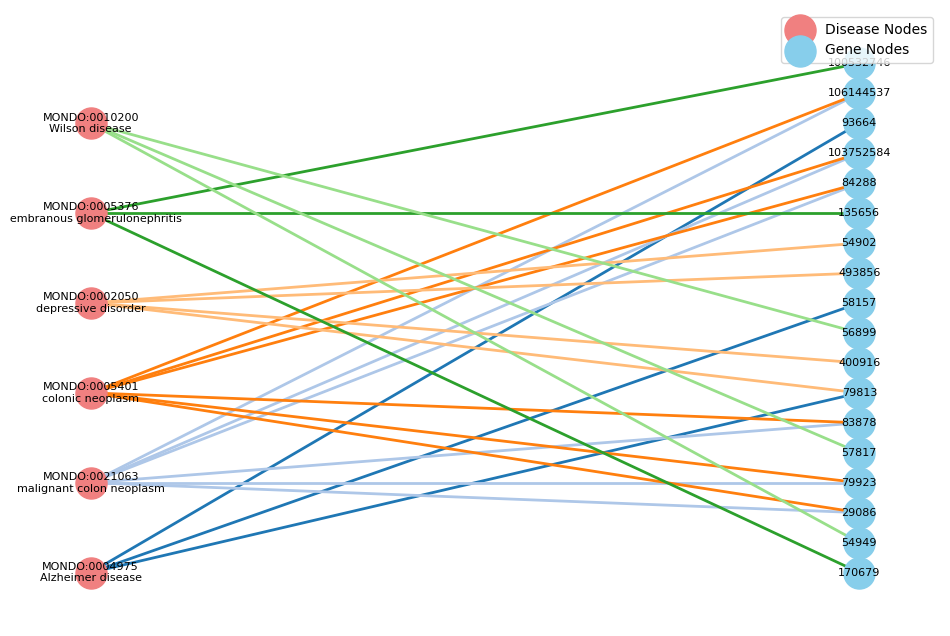

In [22]:
import matplotlib.pyplot as plt
import networkx as nx
import random
from torch_geometric.utils import to_networkx

# Ensure the modified G (without disease-to-disease edges) is used
# Convert the PyTorch Geometric Data to a NetworkX graph and remove disease-to-disease edges
G = to_networkx(new_disgenet_torch_data, to_undirected=True)

# Filter out disease-to-disease edges (if not already done in the previous step)
disease_nodes = set(disease_mappings.values())
disease_to_disease_edges = [(u, v) for u, v in G.edges() if u in disease_nodes and v in disease_nodes]
G.remove_edges_from(disease_to_disease_edges)

# Select the first 6 disease nodes based on disease_mappings
disease_node_indices = list(disease_mappings.values())[:6]

# Limit the number of gene nodes to display per disease node
gene_limit_per_disease = 3
connected_gene_nodes = set()
for disease_node in disease_node_indices:
    neighbors = list(G.neighbors(disease_node))
    gene_neighbors = [n for n in neighbors if n in gene_mappings.values()]
    sampled_genes = random.sample(gene_neighbors, min(gene_limit_per_disease, len(gene_neighbors)))
    connected_gene_nodes.update(sampled_genes)

# Create a subgraph with the selected disease and limited gene nodes
subgraph = G.subgraph(disease_node_indices + list(connected_gene_nodes))

# Create a dictionary for MONDO ID to disease name mapping
mondo_to_name = dict(zip(disgenet_raw['mondo_id'], disgenet_raw['mondo_term']))

# Create a dictionary to label nodes with MONDO IDs, disease names, and Entrez Gene IDs
labels = {}
for disease_id, node in disease_mappings.items():
    if node in disease_node_indices:
        disease_name = mondo_to_name.get(disease_id, "Unknown Disease")
        labels[node] = f"{disease_id}\n{disease_name}"

for gene_id, node in gene_mappings.items():
    if node in connected_gene_nodes:
        labels[node] = gene_id  # Use Entrez Gene ID for gene nodes

# Set fixed positions for a bipartite layout
pos = {}
# Disease nodes on the left
for i, node in enumerate(disease_node_indices):
    pos[node] = (-1, i * (2 / len(disease_node_indices)) - 1)

# Gene nodes on the right
for i, node in enumerate(connected_gene_nodes):
    pos[node] = (1, i * (2 / len(connected_gene_nodes)) - 1)

# Plotting
plt.figure(figsize=(12, 8))

# Draw disease and gene nodes
nx.draw_networkx_nodes(subgraph, pos, nodelist=disease_node_indices, node_color="lightcoral", label="Disease Nodes", node_size=500)
nx.draw_networkx_nodes(subgraph, pos, nodelist=list(connected_gene_nodes), node_color="skyblue", label="Gene Nodes", node_size=500)

# Color each disease's edges uniquely
colors = plt.cm.tab20.colors
for idx, disease_node in enumerate(disease_node_indices):
    disease_edges = [(disease_node, neighbor) for neighbor in subgraph.neighbors(disease_node)]
    nx.draw_networkx_edges(subgraph, pos, edgelist=disease_edges, edge_color=[colors[idx % len(colors)]], width=2)

# Add labels with MONDO IDs, disease names, and Entrez IDs
nx.draw_networkx_labels(subgraph, pos, labels=labels, font_size=8)

# Add legend and display
plt.legend(scatterpoints=1)
plt.axis("off")
plt.show()


<span style="color:teal; font-size:25px; font-weight:bold">Add BioGrid network gene connections to graph </span>


In [23]:
import torch
from torch_geometric.data import Data

# Assuming `filtered_biogrid` is the DataFrame with the BioGRID interactions.
# Columns: ['ID Interactor A', 'ID Interactor B', 'Standardized_confidence_values']

# Filter BioGRID edges based on gene IDs in `new_disgenet_torch_data`
gene_indices = set(gene_mappings.values())  # assuming `gene_mappings` is available

# Step 1: Create an edge list from the BioGRID DataFrame
biogrid_edges = []
for _, row in filtered_biogrid.iterrows():
    gene_a = row['#ID Interactor A']
    gene_b = row['ID Interactor B']
    
    # Check if both genes are in `new_disgenet_torch_data`
    if gene_a in gene_mappings and gene_b in gene_mappings:
        node_a = gene_mappings[gene_a]  # Get the index in `new_disgenet_torch_data`
        node_b = gene_mappings[gene_b]
        biogrid_edges.append([node_a, node_b])

# Step 2: Convert to tensor and add to existing edge_index
biogrid_edges = torch.tensor(biogrid_edges, dtype=torch.long).t().contiguous()  # Shape: [2, num_edges]

# Combine with existing edges in `new_disgenet_torch_data`
new_edge_index = torch.cat([new_disgenet_torch_data.edge_index, biogrid_edges], dim=1)

# Step 3: Update `disgenet_torch_data` with the new edges
new_disgenet_torch_data.edge_index = new_edge_index

# Now `disgenet_torch_data` includes both disease-gene and gene-gene interactions


/var/folders/9q/tl4z5rk169514hgp4blpglqc0000gn/T/ipykernel_83432/368412902.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_biogrid['#ID Interactor A'] = filtered_biogrid['#ID Interactor A'].astype(int)
/var/folders/9q/tl4z5rk169514hgp4blpglqc0000gn/T/ipykernel_83432/368412902.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_biogrid['ID Interactor B'] = filtered_biogrid['ID Interactor B'].astype(int)


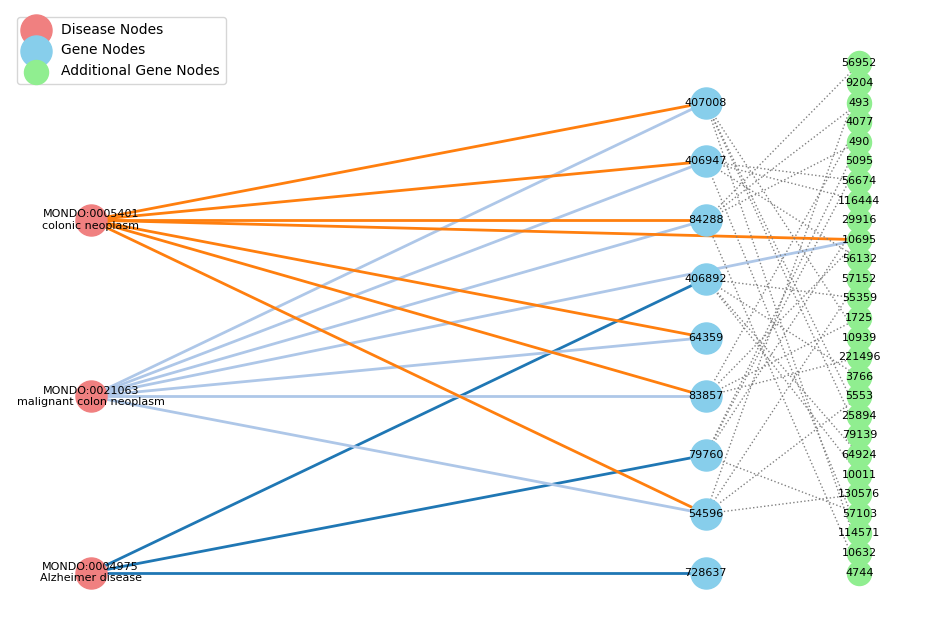

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import random
from torch_geometric.utils import to_networkx

filtered_biogrid['#ID Interactor A'] = filtered_biogrid['#ID Interactor A'].astype(int)
filtered_biogrid['ID Interactor B'] = filtered_biogrid['ID Interactor B'].astype(int)

# Make sure gene_mappings keys and values are also integers for consistency
gene_mappings = {int(k): int(v) for k, v in gene_mappings.items()}

# Now proceed with identifying additional genes connected to blue gene nodes
additional_gene_nodes = set()
additional_gene_edges = []
for blue_gene_node in connected_gene_nodes:
    # Filter biogrid data to find genes connected to each blue gene node
    related_genes = filtered_biogrid[(filtered_biogrid['#ID Interactor A'] == blue_gene_node) | 
                                     (filtered_biogrid['ID Interactor B'] == blue_gene_node)]
    additional_genes = set(related_genes['#ID Interactor A']).union(set(related_genes['ID Interactor B']))
    additional_genes.discard(blue_gene_node)  # Remove the blue node itself from the list
    sampled_additional_genes = random.sample(list(additional_genes), min(4, len(additional_genes)))
    
    # Add to additional gene nodes and edges
    additional_gene_nodes.update(sampled_additional_genes)
    additional_gene_edges.extend([(blue_gene_node, gene) for gene in sampled_additional_genes])


# Convert the PyTorch Geometric Data to a NetworkX graph
G = to_networkx(new_disgenet_torch_data, to_undirected=True)

# Remove disease-to-disease edges if necessary
disease_nodes = set(disease_mappings.values())
disease_to_disease_edges = [(u, v) for u, v in G.edges() if u in disease_nodes and v in disease_nodes]
G.remove_edges_from(disease_to_disease_edges)

# Select the first 6 disease nodes
disease_node_indices = list(disease_mappings.values())[:3]

# Limit the number of gene nodes to display per disease node
gene_limit_per_disease = 3
connected_gene_nodes = set()
for disease_node in disease_node_indices:
    neighbors = list(G.neighbors(disease_node))
    gene_neighbors = [n for n in neighbors if n in gene_mappings.values()]
    sampled_genes = random.sample(gene_neighbors, min(gene_limit_per_disease, len(gene_neighbors)))
    connected_gene_nodes.update(sampled_genes)

# Identify additional gene nodes connected to blue gene nodes
additional_gene_nodes = set()
additional_gene_edges = []
for blue_gene_node in connected_gene_nodes:
    # Filter biogrid data to find genes connected to each blue gene node
    related_genes = filtered_biogrid[(filtered_biogrid['#ID Interactor A'] == blue_gene_node) | 
                                     (filtered_biogrid['ID Interactor B'] == blue_gene_node)]
    additional_genes = set(related_genes['#ID Interactor A']).union(set(related_genes['ID Interactor B']))
    additional_genes.discard(blue_gene_node)  # Remove the blue node itself from the list
    sampled_additional_genes = random.sample(list(additional_genes), min(4, len(additional_genes)))
    
    # Add to additional gene nodes and edges
    additional_gene_nodes.update(sampled_additional_genes)
    additional_gene_edges.extend([(blue_gene_node, gene) for gene in sampled_additional_genes])

# Create a subgraph with the selected nodes
subgraph = G.subgraph(disease_node_indices + list(connected_gene_nodes) + list(additional_gene_nodes))

# Create a dictionary for node labels
labels = {}
for disease_id, node in disease_mappings.items():
    if node in disease_node_indices:
        disease_name = mondo_to_name.get(disease_id, "Unknown Disease")
        labels[node] = f"{disease_id}\n{disease_name}"

# Label existing blue gene nodes
for gene_id, node in gene_mappings.items():
    if node in connected_gene_nodes:
        labels[node] = gene_id  # Use Entrez Gene ID for gene nodes

# Label additional gene nodes
for gene in additional_gene_nodes:
    # If gene ID is not already labeled, add it to labels
    labels[gene] = str(gene)  # Use the gene ID itself as the label

# The rest of the plotting code remains the same
# ...


# Set fixed positions for a clearer layout
pos = {}
# Disease nodes on the left
for i, node in enumerate(disease_node_indices):
    pos[node] = (-1, i * (2 / len(disease_node_indices)) - 1)

# Blue gene nodes on the right
for i, node in enumerate(connected_gene_nodes):
    pos[node] = (1, i * (2 / len(connected_gene_nodes)) - 1)

# Additional gene nodes further to the right
for i, node in enumerate(additional_gene_nodes):
    pos[node] = (1.5, i * (2 / len(additional_gene_nodes)) - 1)

# Plotting
plt.figure(figsize=(12, 8))

# Draw disease and gene nodes
nx.draw_networkx_nodes(subgraph, pos, nodelist=disease_node_indices, node_color="lightcoral", label="Disease Nodes", node_size=500)
nx.draw_networkx_nodes(subgraph, pos, nodelist=list(connected_gene_nodes), node_color="skyblue", label="Gene Nodes", node_size=500)
nx.draw_networkx_nodes(subgraph, pos, nodelist=list(additional_gene_nodes), node_color="lightgreen", label="Additional Gene Nodes", node_size=300)

# Color each disease's edges uniquely
colors = plt.cm.tab20.colors
for idx, disease_node in enumerate(disease_node_indices):
    disease_edges = [(disease_node, neighbor) for neighbor in subgraph.neighbors(disease_node)]
    nx.draw_networkx_edges(subgraph, pos, edgelist=disease_edges, edge_color=[colors[idx % len(colors)]], width=2)

# Draw edges between blue gene nodes and additional gene nodes
nx.draw_networkx_edges(subgraph, pos, edgelist=additional_gene_edges, edge_color="grey", width=1, style="dotted")

# Add labels with MONDO IDs, disease names, and Entrez IDs
nx.draw_networkx_labels(subgraph, pos, labels=labels, font_size=8)

# Add legend and display
plt.legend(scatterpoints=1)
plt.axis("off")
plt.show()


<span style="color:teal; font-size:25px; font-weight:bold">Split data for training, testing and validation </span>


In [25]:
# initialize device setting
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# doing a split of 15% of edges for the test set and the 5% for validation

transform = Compose([ T.NormalizeFeatures(),
                       T.ToDevice(device),
                       T.RandomLinkSplit(num_val = 0.05, num_test= 0.15, is_undirected= True,
                                         split_labels=True, add_negative_train_samples= True),])

train_set, val_set, test_set = transform(new_disgenet_torch_data)
print("Training set: \n", train_set)
print("Validation set: \n", val_set)
print("Test set: \n", test_set)

cpu
Training set: 
 Data(num_nodes=18140, edge_index=[2, 391328], x=[18140, 1], pos_edge_label=[195664], pos_edge_label_index=[2, 195664], neg_edge_label=[195664], neg_edge_label_index=[2, 195664])
Validation set: 
 Data(num_nodes=18140, edge_index=[2, 391328], x=[18140, 1], pos_edge_label=[12228], pos_edge_label_index=[2, 12228], neg_edge_label=[12228], neg_edge_label_index=[2, 12228])
Test set: 
 Data(num_nodes=18140, edge_index=[2, 415784], x=[18140, 1], pos_edge_label=[36686], pos_edge_label_index=[2, 36686], neg_edge_label=[36686], neg_edge_label_index=[2, 36686])


#### Step 5: Train, Test and Validate GAE

In [26]:
# function used to plot ROC curve for GAE and VGAE models
# code adapted from Collab- CS224W Project Disease Gene Interactions.ipynb
def plot_roc_curve(title, model, data):
    model.eval()

    x = data.x
    z = model.encode(x, data.edge_index)

    pos_preds = model.decode(z, data.pos_edge_label_index, sigmoid=True)
    neg_preds = model.decode(z, data.neg_edge_label_index, sigmoid=True)
    preds = torch.cat([pos_preds, neg_preds], dim=0)
    preds = preds.detach().cpu().numpy()

    labels = torch.cat((data.pos_edge_label, data.neg_edge_label), dim=0)
    labels = labels.detach().cpu().numpy()
    fpr, tpr, thresholds = metrics.roc_curve(labels, preds)

    auc= tpr - fpr
    ix = np.argmax(auc)
    best_thresh = thresholds[ix]
    print('Best Threshold=%f' % (best_thresh))

    roc_auc = metrics.roc_auc_score(labels, preds)

    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.plot([0, 1], [0, 1],'r--') 
    plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best=%0.2f' % best_thresh)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc = 'lower right')
    plt.title(title)

    # create a filename based on the title
    sanitized_title = "".join([c if c.isalnum() else "_" for c in title])
    filename = f"../data/figures/{sanitized_title}_roc_curve.png"

    # save the plot
    #plt.savefig(filename)

    plt.show()

    plt.close()


In [27]:
# plots the AP and AUC after each epoch 
# code adapted from Collab- CS224W Project Disease Gene Interactions.ipynb
def plot_training_stats(title, losses, test_auc, test_ap, train_auc, train_ap, save_path=None):

  fig, ax = plt.subplots()
  ax2 = ax.twinx()

  ax.set_xlabel("Training Epochs")
  ax2.set_ylabel("Performance Metric")
  ax.set_ylabel("Loss")

  plt.title(title)
  p1, = ax.plot(losses, "b-", label="training loss")
  p2, = ax2.plot(test_auc, "r-", label="test AUC")
  p3, = ax2.plot(test_ap, "g-", label="test AP")
  p4, = ax2.plot(train_auc, "o-", label="train AUC")
  p5, = ax2.plot(train_ap, "v-", label="train AP")
  plt.legend(handles=[p1, p2, p3, p4, p5])
  
  # Create a filename based on the title
  sanitized_title = "".join([c if c.isalnum() else "_" for c in title])
  filename = f"../data/figures/{sanitized_title}_result_stats.png"

  # Save the plot
  #plt.savefig(filename)

  # Show the plot
  plt.show()

  # Close the plot to avoid displaying it multiple times in interactive environments
  plt.close(fig)
  

In [28]:
unique_dis = len(disgenet_raw['mondo_id'].unique())
# code adapted from Collab- CS224W Project Disease Gene Interactions.ipynb

# following two functions help get the results of the predictions after training is done. 
def get_edge_dot_products(data, model, num_dz_nodes=unique_dis):

  model.eval()
  x = data.x
  z = model.encode(x, data.edge_index).detach().numpy()
  dz_z = z[:num_dz_nodes, :]
  gene_z = z[num_dz_nodes:, :]

  dot_products = np.einsum('ai,bi->ab', dz_z, gene_z)
  return dot_products   # numpy array of shape (num_dz_nodes, num_gene_nodes)


def get_ranked_edges(data_object, model, num_dz_nodes=unique_dis):

  # Get dot products
  edge_dot_products = get_edge_dot_products(data_object, model, num_dz_nodes=num_dz_nodes)
  num_possible_edges = edge_dot_products.shape[0] * edge_dot_products.shape[1]

  # Get indeces, ranked by dot product in descending order. This is a tuple (indeces[0], indeces[1]).
  ranked_edges = np.unravel_index(np.argsort(-1 * edge_dot_products, axis=None), edge_dot_products.shape)
  assert len(ranked_edges[0]) == num_possible_edges

  # Get the corresponding, ranked edge list and ranked dot products. Note that
  # we need to add an offset for the gene_node indeces.
  offset = np.array([np.zeros(num_possible_edges, dtype=int), num_dz_nodes + np.ones(num_possible_edges, dtype=int)]).T
  ranked_edge_list = np.dstack(ranked_edges)[0] + offset
  assert ranked_edge_list.shape[0] == num_possible_edges

  # Get the corresponding ranked dot products
  ranked_dot_products = edge_dot_products[ranked_edges]
  assert ranked_dot_products.shape[0] == num_possible_edges

  return ranked_edge_list, ranked_dot_products


In [29]:
# define the GAE
class GCNEncoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        self.dropout = torch.nn.Dropout(0.5)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x

# initialize the model, optimizer, and hyperparameters
input_dim = num_features
hidden_dim = 500
output_dim = 1
learning_rate = 0.005
epochs = 100

encoder = GCNEncoder(input_dim, hidden_dim, output_dim)
gae_model = GAE(encoder)
gae_model = gae_model.to(device)

###################
###################
###################
optimizer = torch.optim.Adam(gae_model.parameters(), lr=learning_rate)
###################
###################
###################
def weights_init(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)
    elif isinstance(m, GCNConv):
        torch.nn.init.xavier_uniform_(m.lin.weight)
        if m.lin.bias is not None:
            torch.nn.init.zeros_(m.lin.bias)

gae_model.apply(weights_init)



GAE(
  (encoder): GCNEncoder(
    (conv1): GCNConv(1, 500)
    (conv2): GCNConv(500, 1)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): InnerProductDecoder()
)

In [30]:
# define the training and testing functions
def gae_train(train_data, gae_model, optimizer):
    gae_model.train()
    optimizer.zero_grad()
    z = gae_model.encode(train_data.x, train_data.edge_index)
    loss = gae_model.recon_loss(z, train_data.pos_edge_label_index)
    loss.backward()
    optimizer.step()
    return float(loss)

@torch.no_grad()
def gae_test(test_data, gae_model):
    gae_model.eval()
    z = gae_model.encode(test_data.x, test_data.edge_index)
    auc, ap = gae_model.test(z, test_data.pos_edge_label_index, test_data.neg_edge_label_index)
    return auc, ap

losses = []
test_auc = []
test_ap = []
train_aucs = []
train_aps = []

writer = SummaryWriter(log_dir="../data/processed/runs/gae_experiment/run_7_adam")

for epoch in range(1, epochs + 1):
    loss = gae_train(train_set, gae_model, optimizer)
    losses.append(loss)
    
    train_auc, train_ap = gae_test(train_set, gae_model)
    train_aucs.append(train_auc)
    train_aps.append(train_ap)
    
    test_auc_value, test_ap_value = gae_test(test_set, gae_model)
    test_auc.append(test_auc_value)
    test_ap.append(test_ap_value)
    
        # Log the metrics to TensorBoard
    writer.add_scalar("Loss/train", loss, epoch)
    writer.add_scalar("AUC/train", train_auc, epoch)
    writer.add_scalar("AP/train", train_ap, epoch)
    writer.add_scalar("AUC/test", test_auc_value, epoch)
    writer.add_scalar("AP/test", test_ap_value, epoch)

    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train AUC: {train_auc:.4f}, Train AP: {train_ap:.4f}, Test AUC: {test_auc_value:.4f}, Test AP: {test_ap_value:.4f}')
writer.close()

## use tensorboard --logdir=../data/processed/runs/gae_experiment on terminal to view results on tensorboard

Epoch: 001, Loss: 1.3862, Train AUC: 0.8609, Train AP: 0.8764, Test AUC: 0.8553, Test AP: 0.8726
Epoch: 002, Loss: 1.3617, Train AUC: 0.8603, Train AP: 0.8759, Test AUC: 0.8547, Test AP: 0.8721
Epoch: 003, Loss: 1.3208, Train AUC: 0.8602, Train AP: 0.8759, Test AUC: 0.8546, Test AP: 0.8720
Epoch: 004, Loss: 1.2767, Train AUC: 0.8600, Train AP: 0.8757, Test AUC: 0.8543, Test AP: 0.8718
Epoch: 005, Loss: 1.2498, Train AUC: 0.8601, Train AP: 0.8757, Test AUC: 0.8544, Test AP: 0.8719
Epoch: 006, Loss: 1.2606, Train AUC: 0.8601, Train AP: 0.8757, Test AUC: 0.8545, Test AP: 0.8719
Epoch: 007, Loss: 1.2795, Train AUC: 0.8601, Train AP: 0.8757, Test AUC: 0.8545, Test AP: 0.8719
Epoch: 008, Loss: 1.2758, Train AUC: 0.8603, Train AP: 0.8759, Test AUC: 0.8546, Test AP: 0.8720
Epoch: 009, Loss: 1.2606, Train AUC: 0.8605, Train AP: 0.8760, Test AUC: 0.8548, Test AP: 0.8722
Epoch: 010, Loss: 1.2492, Train AUC: 0.8606, Train AP: 0.8762, Test AUC: 0.8549, Test AP: 0.8723
Epoch: 011, Loss: 1.2463, Trai

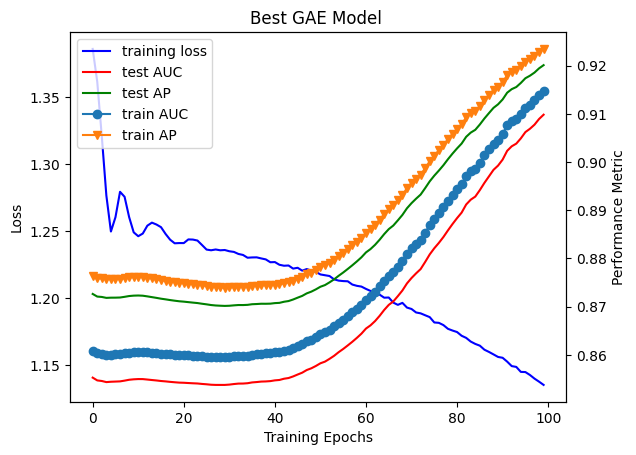

Best Threshold=0.604470


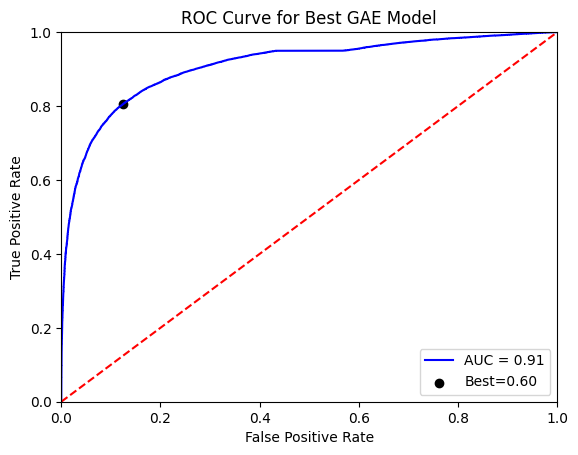

In [31]:
plot_training_stats('Best GAE Model ', losses, test_auc, test_ap, train_aucs, train_aps)
plot_roc_curve('ROC Curve for Best GAE Model',gae_model, test_set)

In [32]:
gae_ranked_edge_list, gae_ranked_dot_products = get_ranked_edges(test_set, gae_model, num_dz_nodes=unique_dis)

In [33]:
gae_ranked_edge_list

array([[  18, 6956],
       [ 852, 6956],
       [  32, 6956],
       ...,
       [3324, 8511],
       [2821, 8511],
       [4114, 8511]])

In [34]:
gae_ranked_dot_products

array([8.4378452e+00, 8.4099836e+00, 8.2084608e+00, ..., 1.4379130e-04,
       1.4151233e-04, 1.4019468e-04], dtype=float32)

In [35]:
# Create reverse mappings for indices back to names
disease_name_mapping = {index: mondo_id for mondo_id, index in disease_mappings.items()}
gene_name_mapping = {index: gene_id for gene_id, index in gene_mappings.items()}

# Function to format the results using the reverse mappings, including MONDO ID and gene symbol
def format_ga_results(ranked_edge_list, ranked_dot_products, disease_name_mapping, gene_name_mapping, disgenet_with_features):
    # Convert MONDO IDs and gene IDs to names for display
    mondo_to_name = dict(zip(disgenet_with_features['mondo_id'], disgenet_with_features['mondo_term']))
    
    # Ensure gene_to_symbol uses consistent types for keys (convert to str)
    gene_to_symbol = {str(k): v for k, v in zip(disgenet_with_features['gene_id'], disgenet_with_features['gene_name'])}
    
    formatted_results = []

    for idx in range(len(ranked_dot_products)):
        disease_idx, gene_idx = ranked_edge_list[idx]
        
        # Retrieve the MONDO ID and gene ID using index mappings
        mondo_id = disease_name_mapping.get(disease_idx, f"Unknown Disease ({disease_idx})")
        gene_id = gene_name_mapping.get(gene_idx, f"Unknown Gene ({gene_idx})")
        
        # Use the MONDO ID and gene ID to get the actual names and symbols
        disease_name = mondo_to_name.get(mondo_id, mondo_id)
        gene_symbol = gene_to_symbol.get(str(gene_id), f"Unknown Gene ({gene_id})")  # Convert gene_id to str
        
        # Format each result to include MONDO ID and gene symbol
        edge_description = f"({mondo_id}-{disease_name}, {gene_id}({gene_symbol}))"
        formatted_results.append((ranked_dot_products[idx], edge_description))

    # Convert to DataFrame for easy viewing and manipulation
    results_df = pd.DataFrame(formatted_results, columns=["Dotprod", "Edges(Disease, Gene)"])
    return results_df

# Generate the formatted DataFrame
formatted_df = format_ga_results(gae_ranked_edge_list, gae_ranked_dot_products, disease_name_mapping, gene_name_mapping, disgenet_with_features)

# Display the DataFrame to check the output format
print(formatted_df.head(15))





     Dotprod                               Edges(Disease, Gene)
0   8.437845    (MONDO:0004989-breast carcinoma, 51742(ARID4B))
1   8.409984   (MONDO:0005814-intestinal cancer, 51742(ARID4B))
2   8.208461     (MONDO:0021100-breast neoplasm, 51742(ARID4B))
3   7.964875       (MONDO:0005371-mood disorder, 51742(ARID4B))
4   7.869541  (MONDO:0002908-glucose metabolism disease, 517...
5   7.846608   (MONDO:0004989-breast carcinoma, 29127(RACGAP1))
6   7.820699  (MONDO:0005814-intestinal cancer, 29127(RACGAP1))
7   7.781615  (MONDO:0024331-colorectal carcinoma, 51742(ARI...
8   7.773508    (MONDO:0004989-breast carcinoma, 50944(SHANK1))
9   7.747840   (MONDO:0005814-intestinal cancer, 50944(SHANK1))
10  7.745698  (MONDO:0004989-breast carcinoma, 347689(SOX2-OT))
11  7.720122  (MONDO:0005814-intestinal cancer, 347689(SOX2-...
12  7.633296    (MONDO:0021100-breast neoplasm, 29127(RACGAP1))
13  7.562184     (MONDO:0021100-breast neoplasm, 50944(SHANK1))
14  7.535130   (MONDO:0021100-breast neo

In [36]:
# filter out tb dot product results only
# Filter the DataFrame for a specific MONDO ID
specific_mondo_id = "MONDO:0018076-tuberculosis"

# Check if the MONDO ID is in the 'Edges(Disease, Gene)' column
tb_dotprod_results = formatted_df[formatted_df["Edges(Disease, Gene)"].str.contains(specific_mondo_id, regex=False)]

# Display the filtered DataFrame
print(tb_dotprod_results)


           Dotprod                             Edges(Disease, Gene)
102233    2.006077      (MONDO:0018076-tuberculosis, 51742(ARID4B))
163319    1.865512     (MONDO:0018076-tuberculosis, 29127(RACGAP1))
173022    1.848132      (MONDO:0018076-tuberculosis, 50944(SHANK1))
174230    1.841521    (MONDO:0018076-tuberculosis, 347689(SOX2-OT))
195679    1.765663       (MONDO:0018076-tuberculosis, 79730(NSUN7))
...            ...                                              ...
73958118  0.036081       (MONDO:0018076-tuberculosis, 85417(CCNB3))
74350835  0.032791  (MONDO:0018076-tuberculosis, 103157000(PAUPAR))
74538519  0.030918     (MONDO:0018076-tuberculosis, 131566(DCBLD2))
75758643  0.015143       (MONDO:0018076-tuberculosis, 64747(MFSD1))
76027317  0.007344       (MONDO:0018076-tuberculosis, 83538(TTC25))

[11557 rows x 2 columns]


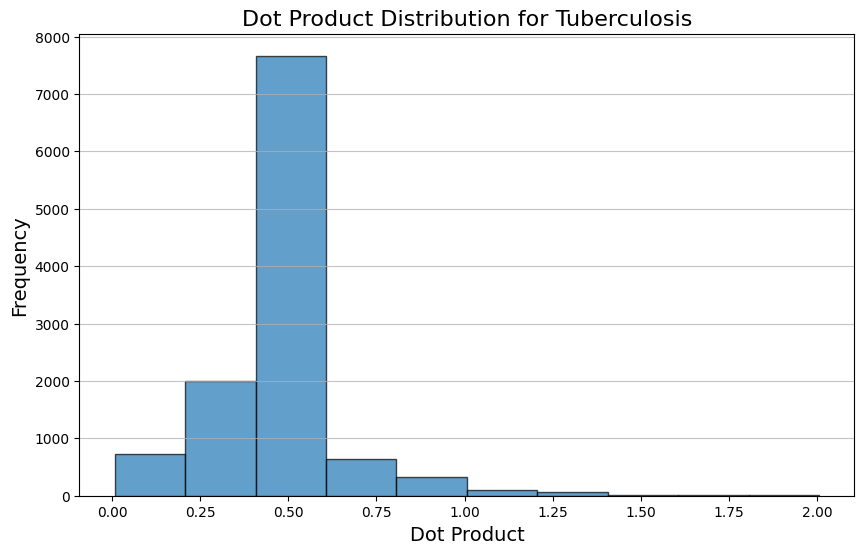

In [37]:
import matplotlib.pyplot as plt

# Plotting the dot product distribution for tuberculosis results
plt.figure(figsize=(10, 6))
plt.hist(tb_dotprod_results['Dotprod'], bins=10, edgecolor='black', alpha=0.7)
plt.title('Dot Product Distribution for Tuberculosis', fontsize=16)
plt.xlabel('Dot Product', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', alpha=0.75)

# Show the plot
plt.show()


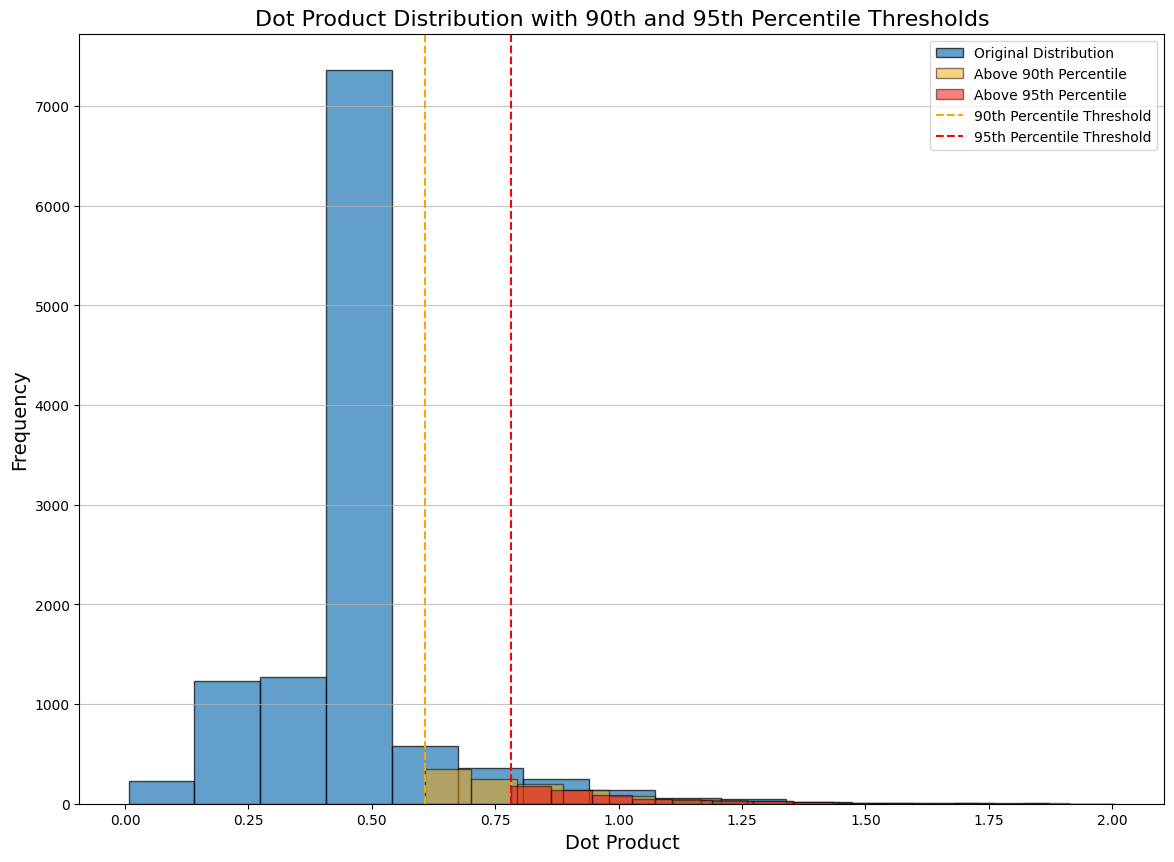

In [38]:
import matplotlib.pyplot as plt

# Assuming `tb_dotprod_results` is your DataFrame with the dot product values
# Calculate the 90th and 95th percentile thresholds
threshold_90 = tb_dotprod_results['Dotprod'].quantile(0.90)
threshold_95 = tb_dotprod_results['Dotprod'].quantile(0.95)

# Filter results with dot products above the chosen thresholds
strong_associations_90 = tb_dotprod_results[tb_dotprod_results['Dotprod'] >= threshold_90]
strong_associations_95 = tb_dotprod_results[tb_dotprod_results['Dotprod'] >= threshold_95]

# Plotting the distribution of dot products with threshold lines for 90th and 95th percentiles
plt.figure(figsize=(14, 10))
plt.hist(tb_dotprod_results['Dotprod'], bins=15, edgecolor='black', alpha=0.7, label='Original Distribution')
plt.hist(strong_associations_90['Dotprod'], bins=15, edgecolor='black', alpha=0.5, color='orange', label='Above 90th Percentile')
plt.hist(strong_associations_95['Dotprod'], bins=15, edgecolor='black', alpha=0.5, color='red', label='Above 95th Percentile')

# Adding vertical lines for threshold values
plt.axvline(threshold_90, color='orange', linestyle='--', linewidth=1.5, label='90th Percentile Threshold')
plt.axvline(threshold_95, color='red', linestyle='--', linewidth=1.5, label='95th Percentile Threshold')

# Plot settings
plt.title('Dot Product Distribution with 90th and 95th Percentile Thresholds', fontsize=16)
plt.xlabel('Dot Product', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend()
plt.grid(axis='y', alpha=0.75)

# Show the plot
plt.show()
